In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fastai.vision.all import *
from shopee_utils import *
from train_utils import *
import sklearn.metrics as skm
from tqdm.notebook import tqdm

from fastai.vision.learner import _resnet_split
import h5py
import timm

In [ ]:
import debugpy
debugpy.listen(5678)

In [6]:
def efficientnet_b0(pretrained): return timm.create_model('efficientnet_b0', pretrained=pretrained)
def efficientnet_b1(pretrained): return timm.create_model('efficientnet_b1', pretrained=pretrained)
def efficientnet_b2(pretrained): return timm.create_model('efficientnet_b2', pretrained=pretrained)

In [7]:
class conf():
    bs = 64
    #'arch':resnet34,
    arch = efficientnet_b0
    arcface_m=.4
    arcface_s=30


In [8]:
train_df = add_splits(pd.read_csv(PATH/'train.csv'))


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


In [9]:
def get_img_file(row):
    img =row.image
    fn  = PATH/'train_images'/img
    if not fn.is_file():
        fn = PATH/'test_images'/img
    return fn

In [10]:
data_block = DataBlock(blocks = (ImageBlock(), CategoryBlock(vocab=train_df.label_group.to_list())),
                 splitter=ColSplitter(),
                 #splitter=RandomSplitter(),
                 get_y=ColReader('label_group'),
                 get_x=get_img_file,
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75),
                 )
dls = data_block.dataloaders(train_df, bs=conf.bs,num_workers=16)

In [11]:
class ArcFaceClassifier(nn.Module):
    def __init__(self, in_features, output_classes):
        super().__init__()
        self.W = nn.Parameter(torch.Tensor(in_features, output_classes))
        nn.init.kaiming_uniform_(self.W)
    def forward(self, x):
        x_norm = F.normalize(x)
        W_norm = F.normalize(self.W, dim=0)
        return x_norm @ W_norm
    


In [42]:
class ResnetArcFace(nn.Module):
    def __init__(self):
        super().__init__()
        self.body = create_body(conf.arch, cut=-2)
        nf = num_features_model(nn.Sequential(*self.body.children()))
        self.after_conv=nn.Sequential(
            AdaptiveConcatPool2d(),
            Flatten(),
            nn.BatchNorm1d(nf*2),
            nn.Dropout(.25))
        self.classifier = ArcFaceClassifier(nf*2, dls.c)
        self.outputEmbs = False
    def forward(self, x):
        x = self.body(x)
        embeddings = self.after_conv(x)
        if self.outputEmbs:
            return embeddings
        return self.classifier(embeddings)

In [43]:
def split_2way(model):
    return L(params(model.body),
            params(model.classifier))

In [120]:
def modules_params(modules):
    return list(itertools.chain(*modules.map(params)))

def split_b0(model):
    body =model.body 
    b0_children = list(body.children())
    convs = b0_children[3]
    group1 =L(b0_children[:3]) + L(convs[:2]) 
    group2 = L(convs[2:]) + L(b0_children[4:])
    group3 = L([model.after_conv,model.classifier])
    return [modules_params(g) for g in [group1,group2,group3]]

In [139]:
#opt_func=RMSProp
opt_func=Adam
loss_func=functools.partial(arcface_loss, m=conf.arcface_m, s=conf.arcface_s)
learn = Learner(dls,ResnetArcFace(),splitter=split_b0, 
                opt_func=opt_func, loss_func=arcface_loss, cbs = F1FromEmbs, metrics=FakeMetric())

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b2_ra-bcdf34b7.pth" to /home/slex/.cache/torch/hub/checkpoints/efficientnet_b2_ra-bcdf34b7.pth


In [140]:
learn.fine_tune(8,1e-2, lr_mult=50)

epoch,train_loss,valid_loss,F1 embeddings,time
0,18.759026,None,0.707569,01:40


epoch,train_loss,valid_loss,F1 embeddings,time
0,14.589975,None,0.739926,02:03
1,12.927155,None,0.755388,02:03
2,11.088046,None,0.769582,02:03
3,8.971631,None,0.778303,02:04
4,7.041372,None,0.778677,02:05
5,5.251138,None,0.783466,02:05
6,4.006961,None,0.783025,02:05
7,3.499743,None,0.783289,02:05


In [128]:
learn.save('b0_788')

Path('models/b0_788.pth')

In [21]:
learn.load('resnet34_arcface')

# VALIDATION

In [131]:
model = learn.model.eval().cuda()
model.outputEmbs = True

In [132]:
embs, y = embs_from_model(model, dls.valid)


  0%|          | 0/108 [00:00<?, ?it/s]

0.788 at 4.680239200592041 pairs or 0.402 threshold


0.7880453269725372

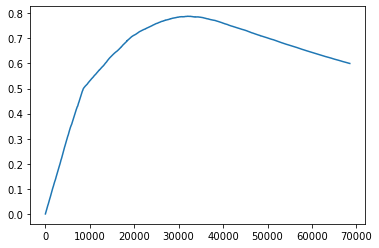

In [133]:
f1_from_embs(embs,y, True)